### Import Packages and Download Dataset

In [1]:
import kagglehub
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2

c:\Users\davea\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PATH = "archive/"
print(PATH)

archive/


### Load Data and Preprocessing

In [3]:
DATA_PATH = os.path.join(PATH, "CrashBest")
TABLE_PATH = os.path.join(PATH, "Crash_Table.csv")

TARGET_SIZE = (224, 224)

In [4]:
df = pd.read_csv(TABLE_PATH)
df.head()

,vidname,frame_1,frame_2,frame_3,frame_4,frame_5,frame_6,frame_7,frame_8,frame_9,...,frame_46,frame_47,frame_48,frame_49,frame_50,startframe,youtubeID,timing,weather,egoinvolve
0,1,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,285,0,Day,Normal,Yes
1,2,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,646,0,Day,Normal,Yes
2,3,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,972,0,Day,Normal,Yes
3,4,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1257,0,Day,Normal,Yes
4,5,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,462,10,Day,Snowy,Yes


In [5]:
df_sampled = df.sample(100, random_state=40)

In [6]:
def get_file_name(video_name, frame_name):
  return f"C_{video_name:06}_{frame_name:02}.jpg"

def get_video_frame_paths(video_name):
  frame_paths = []
  for i in range (1, 51):
    frame_path = os.path.join(DATA_PATH, get_file_name(video_name, i))
    frame_paths.append(frame_path)
  return frame_paths

In [7]:
video_names = []
raw_images =[]
labels = []
timings = []

for idx, row in df_sampled.iterrows():
  frame_paths = get_video_frame_paths(row["vidname"])
  if all(os.path.exists(frame_path) for frame_path in frame_paths):
    for frame_path in frame_paths:
      image = cv2.imread(frame_path)
      image = cv2.resize(image, TARGET_SIZE)
      raw_images.append(image)
      
    for i in range(1, 51):
      labels.append(row[f"frame_{i}"])
      timings.append(row["timing"])
      video_names.append(row["vidname"])

print("Length of video_names: ", len(video_names))
print("Length of image_paths: ", len(raw_images))
print("Length of labels: ", len(labels))
print("Length of timings: ", len(timings))

Length of video_names:  5000
Length of image_paths:  5000
Length of labels:  5000
Length of timings:  5000


In [8]:
x_train, x_temp, y_train, y_temp = train_test_split(raw_images, labels, test_size=0.2, random_state=40)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=40)

In [9]:
model = MobileNetV2(include_top=False, input_shape=(224, 224, 3))
for layer in model.layers:
    layer.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [10]:
x = model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(50, activation='relu')(x)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(inputs=model.input, outputs=output_layer)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 5,394,085 (20.58 MB)

 Trainable params: 3,136,101 (11.96 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
EPOCHS = 10
BATCH_SIZE = 32

In [13]:
history = model.fit(np.array(x_train), np.array(y_train), epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(np.array(x_val), np.array(y_val)))

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 25s 177ms/step - accuracy: 0.6400 - loss: 2.8839 - val_accuracy: 0.7320 - val_loss: 0.5769
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 173ms/step - accuracy: 0.7397 - loss: 0.4911 - val_accuracy: 0.7320 - val_loss: 0.3724
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 174ms/step - accuracy: 0.7431 - loss: 0.3366 - val_accuracy: 0.7320 - val_loss: 0.3402
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 174ms/step - accuracy: 0.7832 - loss: 0.2708 - val_accuracy: 0.9080 - val_loss: 0.3093
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 177ms/step - accuracy: 0.9390 - loss: 0.2365 - val_accuracy: 0.8940 - val_loss: 0.2990
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 176ms/step - accuracy: 0.9472 - loss: 0.2255 - val_accuracy: 0.8360 - val_loss: 0.4858
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 176ms/step - accuracy: 0.9602 - loss: 0.1869 - val_accuracy: 0.8840 - val_loss: 0.3355
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 176ms/step - accuracy: 0.9736 - loss: 0

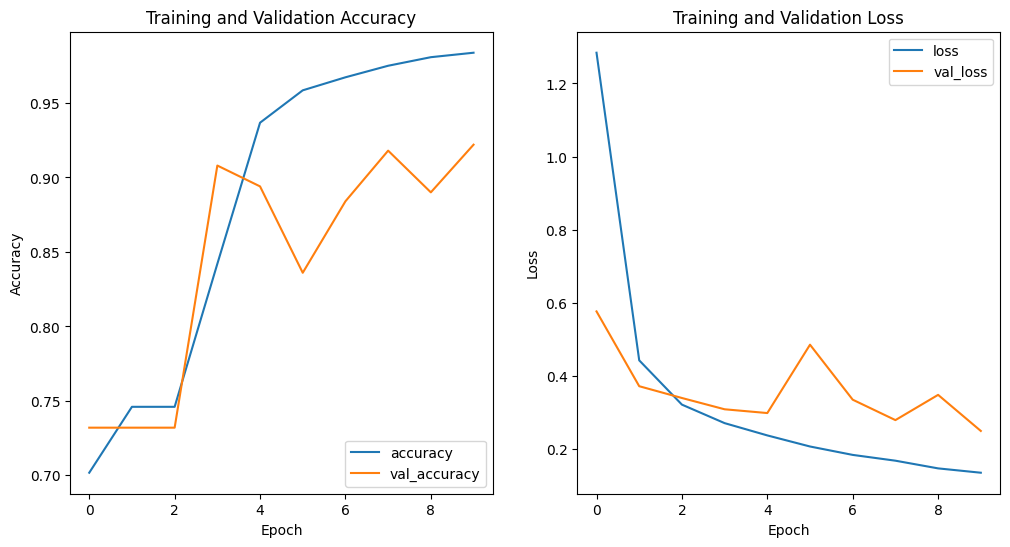

In [14]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.show()

In [15]:
test_loss, test_acc = model.evaluate(np.array(x_test), np.array(y_test), verbose=2)

print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

16/16 - 2s - 156ms/step - accuracy: 0.9540 - loss: 0.1948
Test accuracy: 0.9539999961853027
Test loss: 0.1948118358850479


In [16]:
y_pred = model.predict(np.array(x_test))
y_pred = np.round(y_pred)

print("True Labels vs. Predicted Labels:")
for i in range(10):
  print(f"True Label: {int(y_test[i])}, Predicted Label: {int(y_pred[i])}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step
True Labels vs. Predicted Labels:
True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 0
True Label: 1, Predicted Label: 0
True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 1
True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 0
True Label: 1, Predicted Label: 1


C:\Users\davea\AppData\Local\Temp\ipykernel_31284\1299305344.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"True Label: {int(y_test[i])}, Predicted Label: {int(y_pred[i])}")


In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       358
           1       0.94      0.89      0.92       142

    accuracy                           0.95       500
   macro avg       0.95      0.94      0.94       500
weighted avg       0.95      0.95      0.95       500



<Figure size 800x600 with 0 Axes>

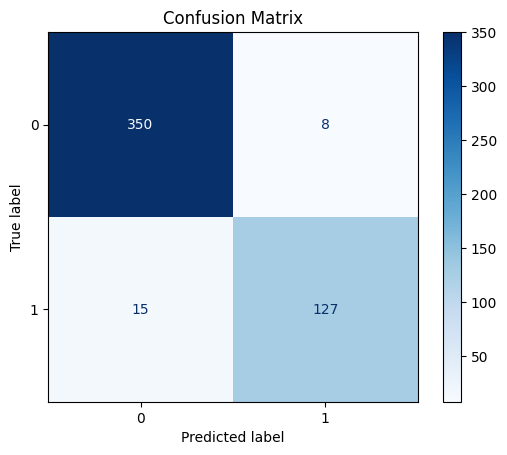

In [18]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [20]:
model.save('models/mobilenetv2.keras')